#  HTRU2 Data Set 

HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South).

In [2]:
%matplotlib inline
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

PULS_URL = "https://gitlab.com/emrevoid/uni/dia/project/seintz/-/raw/master/HTRU_2.csv"
response = requests.get(PULS_URL)
file_object = io.StringIO(response.content.decode('utf-8'))
pulsds = pd.read_csv(file_object, header=0, index_col=False, sep=r'\s*,\s*', engine='python')

pulsds.head()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.56,55.68,-0.23,-0.70,3.20,19.11,7.98,74.24,0
1,102.51,58.88,0.47,-0.52,1.68,14.86,10.58,127.39,0
2,103.02,39.34,0.32,1.05,3.12,21.74,7.74,63.17,0
3,136.75,57.18,-0.07,-0.64,3.64,20.96,6.90,53.59,0
4,88.73,40.67,0.60,1.12,1.18,11.47,14.27,252.57,0


In [3]:
pulsds["class"].value_counts()

0    16259
1     1639
Name: class, dtype: int64

In [4]:
pulsds["class"].value_counts(normalize=True)

0   0.91
1   0.09
Name: class, dtype: float64

In [5]:
pulsds.describe()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
count,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00,17898.00
mean,111.08,46.55,0.48,1.77,12.61,26.33,8.30,104.86,0.09
std,25.65,6.84,1.06,6.17,29.47,19.47,4.51,106.51,0.29
min,5.81,24.77,-1.88,-1.79,0.21,7.37,-3.14,-1.98,0.00
25%,100.93,42.38,0.03,-0.19,1.92,14.44,5.78,34.96,0.00
50%,115.08,46.95,0.22,0.20,2.80,18.46,8.43,83.06,0.00
75%,127.09,51.02,0.47,0.93,5.46,28.43,10.70,139.31,0.00
max,192.62,98.78,8.07,68.10,223.39,110.64,34.54,1191.00,1.00


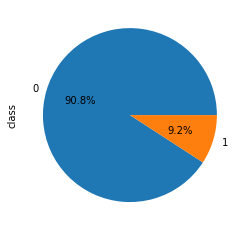

In [6]:
pulsds["class"].value_counts().plot.pie(autopct='%1.1f%%');

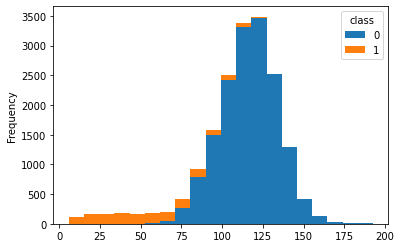

In [7]:
pulsds.pivot(columns="class")["Profile_mean"].plot.hist(bins=20, stacked=True);

In [8]:
class_map = {0: "blue", 1: "red"}
class_color = pulsds["class"].map(class_map)
class_color.head()

0    blue
1    blue
2    blue
3    blue
4    blue
Name: class, dtype: object

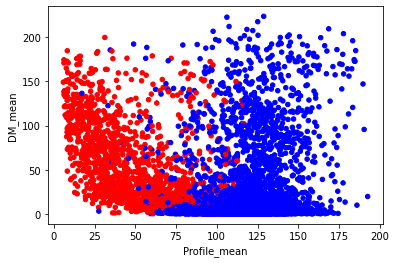

In [9]:
pulsds.plot.scatter("Profile_mean", "DM_mean", c=class_color);

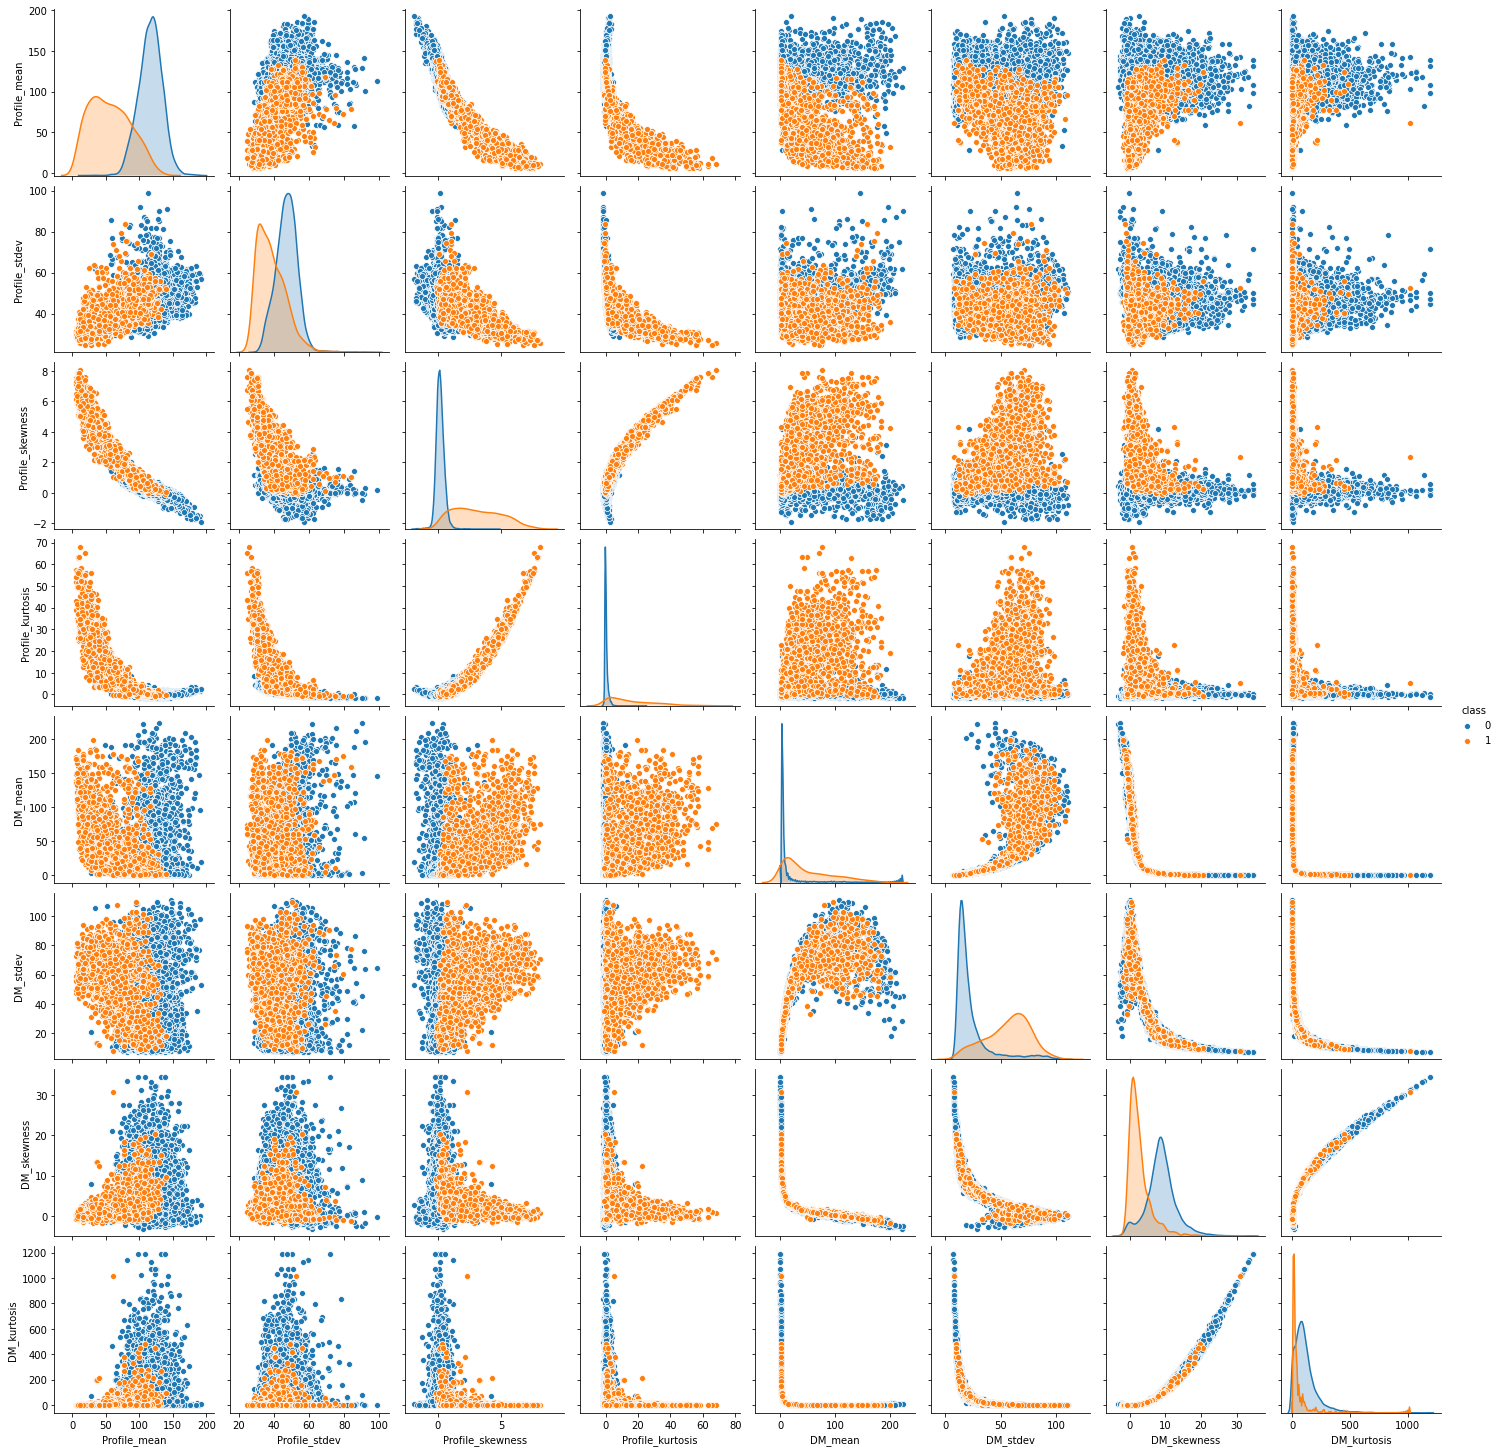

In [10]:
sns.pairplot(data=pulsds, hue="class");

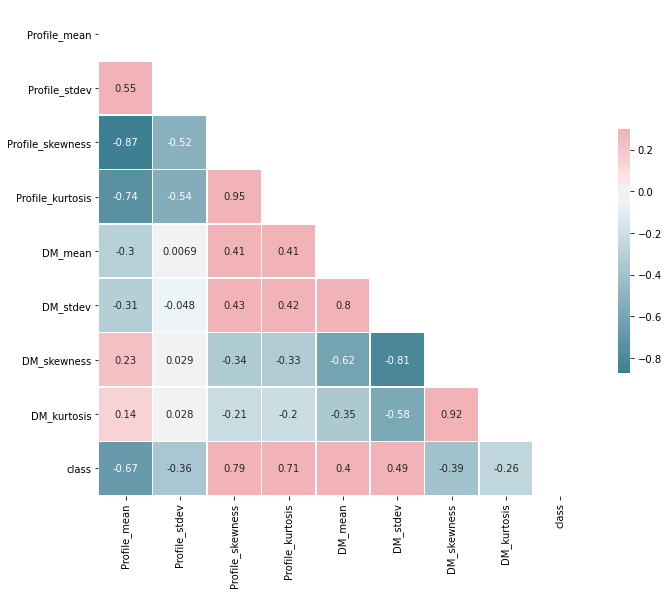

In [11]:
def plot_correlation(dataset):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dataset, mask=mask, cmap=cmap, vmax=.3, center=0,
                annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5});
    
    
plot_correlation(pulsds.corr())

## preparazione dataset

### gestione dei valori nulli

In [12]:
pulsds.isna().sum()

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
class               0
dtype: int64

non ci sono valori nulli da gestire

In [13]:
X = pulsds.drop('class', axis=1)
y = pulsds['class']

In [14]:
pulsds.shape

(17898, 9)

In [15]:
pulsds["class"].value_counts()

0    16259
1     1639
Name: class, dtype: int64

In [16]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0, 16259), (1, 16259)]


In [17]:
sns.set();
pulsds_oversampled = pd.concat([X_resampled, y_resampled], axis=1)

In [18]:
pulsds.shape

(17898, 9)

In [19]:
pulsds_oversampled["class"].value_counts()

1    16259
0    16259
Name: class, dtype: int64

In [20]:
pulsds_oversampled["class"].value_counts(normalize=True)

1   0.50
0   0.50
Name: class, dtype: float64

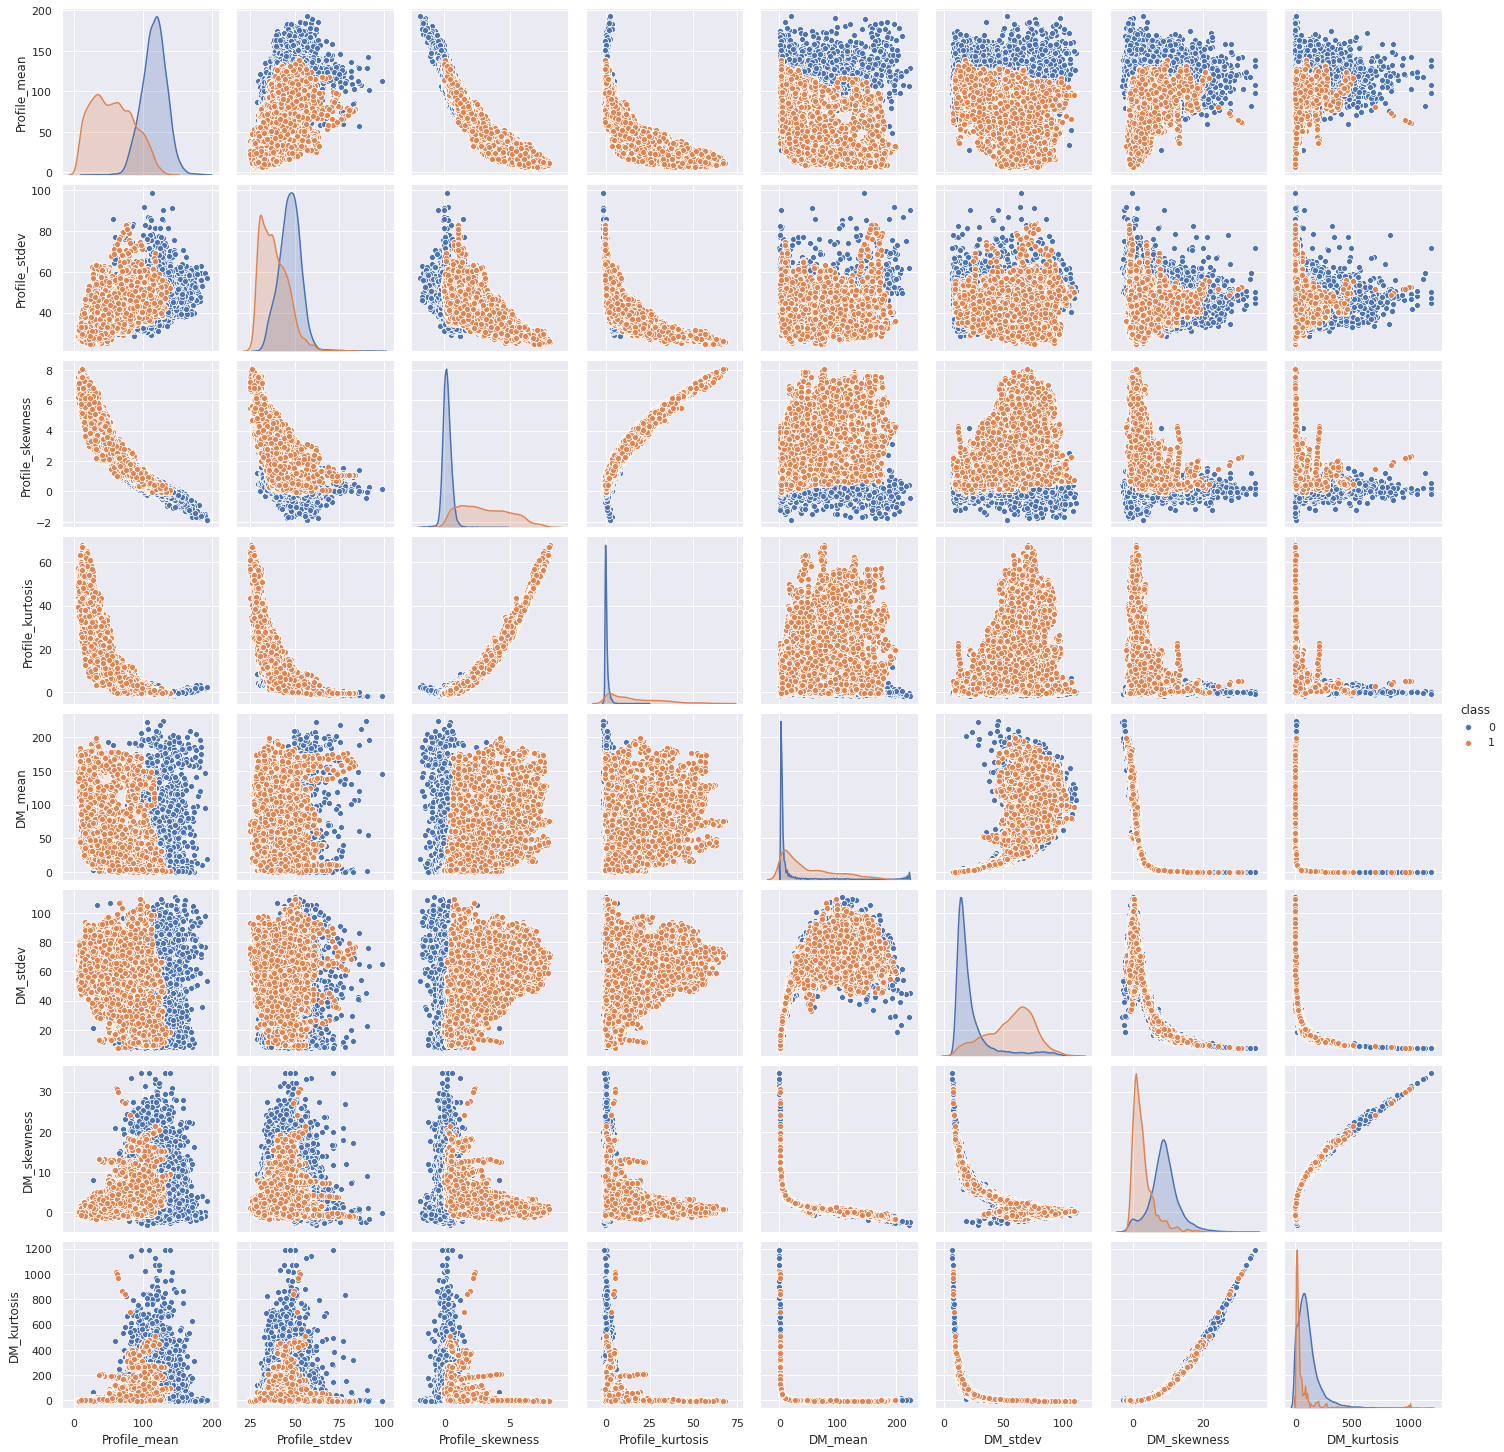

In [21]:
sns.pairplot(data=pulsds_oversampled, hue="class");

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=1/3,
    random_state=42,
)

In [23]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

1    3619
0    3607
Name: class, dtype: int64
1    3619
0    3607
Name: class, dtype: int64
1    3618
0    3608
Name: class, dtype: int64


## Perceptron

In [24]:
scale = [None, StandardScaler()]
polynomial = [PolynomialFeatures(include_bias=False)]
grid = [
    {
        "std" : scale,
        "perceptron__penalty": ["l2", "l1", "elasticnet"],
        "perceptron__alpha": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_perceptron = Pipeline([
    ('std', None),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ('perceptron', Perceptron(random_state=42))
])

gs = GridSearchCV(model_perceptron, grid, cv=skf)
gs.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print(gs.best_params_)

Accuracy on train 93.40%
Accuracy on val 93.03%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'std': StandardScaler()}


### stessa operazione su ds unbalanced

In [25]:
X_train_unb, X_val_unb, y_train_unb, y_val_unb = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42,
)

In [26]:
# Perceptron with standard scaler
model_perceptron_unb = Pipeline([
    ('std', None),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ('perceptron', Perceptron(random_state=42))
])

gs_unb = GridSearchCV(model_perceptron_unb, grid, cv=skf)
gs_unb.fit(X_train_unb, y_train_unb);

print('Accuracy on train {:.2f}%'.format(gs_unb.score(X_train_unb, y_train_unb)*100))
print('Accuracy on val {:.2f}%'.format(gs_unb.score(X_val_unb, y_val_unb)*100))
print(gs_unb.best_params_)

Accuracy on train 96.65%
Accuracy on val 96.75%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'std': StandardScaler()}


## confusion matrix

In [27]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


### balanced

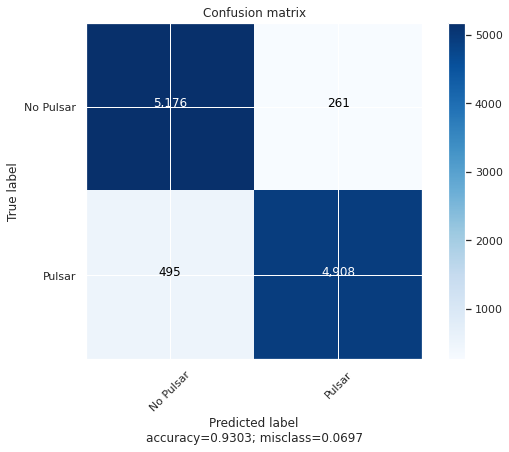

In [28]:
y_pred = gs.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm, target_names=['No Pulsar', 'Pulsar'], normalize=False)

### unbalanced

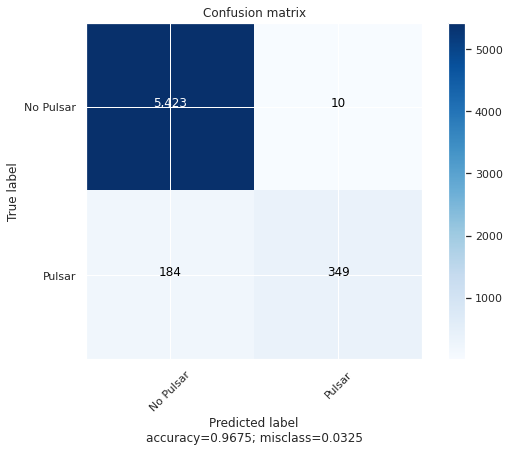

In [29]:
y_pred_unb = gs_unb.predict(X_val_unb)
cm_unb = confusion_matrix(y_val_unb, y_pred_unb)
plot_confusion_matrix(cm_unb, target_names=['No Pulsar', 'Pulsar'], normalize=False)

## precison & recall

### balanced

In [30]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      5437
           1       0.95      0.91      0.93      5403

    accuracy                           0.93     10840
   macro avg       0.93      0.93      0.93     10840
weighted avg       0.93      0.93      0.93     10840



### unbalanced

In [31]:
print(classification_report(y_val_unb, y_pred_unb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5433
           1       0.97      0.65      0.78       533

    accuracy                           0.97      5966
   macro avg       0.97      0.83      0.88      5966
weighted avg       0.97      0.97      0.96      5966



## regressione logistica

In [32]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "logreg__penalty": ["l1"],
        "logreg__C": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_logreg = Pipeline([
    ('std', None),
    ('logreg', LogisticRegression(solver="saga", dual=False, random_state=42, max_iter=10000))
])

gs_logreg = GridSearchCV(model_logreg, grid, cv=skf)
gs_logreg.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs_logreg.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_logreg.score(X_val, y_val)*100))
print(gs_logreg.best_params_)

Accuracy on train 94.47%
Accuracy on val 94.13%
{'logreg__C': 1.0, 'logreg__penalty': 'l1', 'std': StandardScaler()}


In [33]:
y_pred_logreg = gs_logreg.predict(X_val)
print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5437
           1       0.97      0.91      0.94      5403

    accuracy                           0.94     10840
   macro avg       0.94      0.94      0.94     10840
weighted avg       0.94      0.94      0.94     10840



## SVM 

In [34]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "svm__C": np.logspace(-3, 3, 3)
    },
]

# Perceptron with standard scaler
model_svm = Pipeline([
    ('std', None),
    ('svm', SVC())
])

gs_svm = GridSearchCV(model_svm, grid, cv=skf)
gs_svm.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs_svm.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_svm.score(X_val, y_val)*100))
print(gs_svm.best_params_)

Accuracy on train 95.73%
Accuracy on val 95.16%
{'std': StandardScaler(), 'svm__C': 1000.0}


In [35]:
y_pred_svm = gs_svm.predict(X_val)
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5437
           1       0.98      0.92      0.95      5403

    accuracy                           0.95     10840
   macro avg       0.95      0.95      0.95     10840
weighted avg       0.95      0.95      0.95     10840

